## Analysis of COVID-19 Finacial Policy Response

The aim was to create an overview of the various responses to the COVID-19 epidemic as well as a brief look at the overall economic outlook through the lens of GDP. 

In [240]:
import pandas as pd
import numpy as np
from scipy import stats
import missingno

import matplotlib.pyplot as plt
from matplotlib import cm
import seaborn as sns
from wordcloud import WordCloud, STOPWORDS 
import nltk
# Importing Natural language Processing toolkit.
from PIL import Image
# from python imaging library
import plotly.graph_objects as go

import matplotlib.dates as mdates
from datetime import datetime


cov19 = pd.ExcelFile('covid-fci-data.xlsx')
cov_df = cov19.parse('Raw data') 
gdp_df = pd.read_csv('GEPData.csv')

In [241]:
# display an initial look at the data from the excel file
cov_df.head()

,Iso 3 Code,Level of income,Region,Country,Date (at or prior to),Entry date,Level 1 policy measure,Level 2 policy measure,Detail
0,CHN,Upper middle income,EAP,China,2020-02-01,2020-03-21,Banking Sector,Operational continuity,Require banks and insurance companies to ensur...
1,CAN,High income,Other G20,Canada,2020-02-03,2020-03-21,Financial Markets/NBFI,Market functioning,BoC also created a Bankers Acceptance Purchase...
2,THA,Upper middle income,EAP,Thailand,2020-02-05,2020-03-21,Liquidity/funding,Policy rate,BOT unexpectedly cut its benchmark interest ra...
3,RUS,Upper middle income,ECA,Russian Federation,2020-02-07,2020-03-21,Liquidity/funding,Policy rate,Policy rates were reduced by 25 basis points t...
4,BLR,Upper middle income,ECA,Belarus,2020-02-19,2020-03-31,Liquidity/funding,Policy rate,"As of February 19, 2020, the rate on overnight..."


In [242]:
cov_df.columns

Index(['Iso 3 Code', 'Level of income', 'Region', 'Country',
       'Date (at or prior to)', 'Entry date', 'Level 1 policy measure',
       'Level 2 policy measure', 'Detail'],
      dtype='object')

## Data Cleaning

## Financial Response Dataset

The table presented is formatted correctly for analysis. There are 9 seperate columns each containing relevant data for the analysis other than 'Iso 3 Code' as it gives the same information as 'Country'. We will therefore drop this from the set.

In [243]:
#drop columns from dataframe
cov_df.drop(columns=['Iso 3 Code'], inplace=True)


In [244]:
#describ shape of dataframe
cov_df.shape

(2562, 8)

The missing values of the set need to be identified and dealt with to complete the dataframe

In [245]:
# get the number of missing data points per column
missing_values_count = cov_df.isnull().sum()

# look at the # of missing points in the first ten columns
missing_values_count

Level of income             0
Region                      0
Country                     0
Date (at or prior to)       2
Entry date                  4
Level 1 policy measure      0
Level 2 policy measure    127
Detail                      1
dtype: int64

The main issue is with the level 2 policy measures. On further inspection of these values it seems the data all falls within the level 1 policy measure involving the Banking sector. The collection of the data seems unable to classify these policies further. Therefore they can be changed to 'other' so as not to lose the data and the presence of a detail column will allow us to explore these instances further if needed

In [246]:
cov_df["Level 2 policy measure"].fillna("Other", inplace = True) 

The remaining null values regard dates of entry. This will be hard to locate so we will drop these specific rows instead as they make up a small % of the datafame

In [247]:
# drop rows with null values
cov_df.dropna(inplace=True)


The dataframe should now contain values for all entries

In [248]:
# get the number of missing data points per column
missing_values_count = cov_df.isnull().sum()

# look at the # of missing points in the first ten columns
missing_values_count

Level of income           0
Region                    0
Country                   0
Date (at or prior to)     0
Entry date                0
Level 1 policy measure    0
Level 2 policy measure    0
Detail                    0
dtype: int64

The data in 'Country','Level 1 policy measure' and 'Level 2 policy measure' will also be checked for any mistakes

In [249]:
cov_df['Country'].unique()

array(['China', 'Canada', 'Thailand', 'Russian Federation', 'Belarus',
       'Indonesia', 'Japan', 'Uganda', 'Italy', 'Brazil', 'Australia',
       'EU/Eurozone', 'Malaysia', 'Hong Kong SAR, China', 'Argentina',
       'Jordan', 'Mexico', 'Bahrain', 'Mauritius', 'Qatar',
       'Saudi Arabia', 'South Africa', 'United Arab Emirates',
       'South Korea', 'UK', 'Germany', 'Turkey', 'United States',
       'Czech Republic', 'Dominican Republic', 'India', 'Kenya', 'Panama',
       'Sri Lanka', 'Morocco', 'Philippines', 'Spain', 'Tunisia',
       'Vietnam', 'Armenia', 'France', 'Kyrgyz Republic', 'Nigeria',
       'Uzbekistan', 'Azerbaijan', 'Bulgaria', 'Cameroon', 'Paraguay',
       'Peru', 'Senegal', 'Albania', 'Algeria', 'Bolivia', 'Chile',
       'Colombia', 'Costa Rica', 'Croatia', 'Ecuador', 'Egypt, Arab Rep.',
       'Georgia', 'Ghana', 'Hungary', 'Kazakhstan', 'Kuwait', 'Maldives',
       'Moldova', 'Mozambique', 'Oman', 'Pakistan', 'Poland', 'Romania',
       'Rwanda', 'Serbia', 

As the analysis is focused on specific coutries as well as being linked to other datasets, the various indexes within the set will be dropped

In [250]:
indexed = ['EU/Eurozone','Kyrgyz Republic','West Bank and Gaza',
           'European Union','G20','OECS', 'WAEMU', 'CEMAC']
cov_df = cov_df[~cov_df['Country'].isin(indexed)]
cov_df['Country'].unique()

array(['China', 'Canada', 'Thailand', 'Russian Federation', 'Belarus',
       'Indonesia', 'Japan', 'Uganda', 'Italy', 'Brazil', 'Australia',
       'Malaysia', 'Hong Kong SAR, China', 'Argentina', 'Jordan',
       'Mexico', 'Bahrain', 'Mauritius', 'Qatar', 'Saudi Arabia',
       'South Africa', 'United Arab Emirates', 'South Korea', 'UK',
       'Germany', 'Turkey', 'United States', 'Czech Republic',
       'Dominican Republic', 'India', 'Kenya', 'Panama', 'Sri Lanka',
       'Morocco', 'Philippines', 'Spain', 'Tunisia', 'Vietnam', 'Armenia',
       'France', 'Nigeria', 'Uzbekistan', 'Azerbaijan', 'Bulgaria',
       'Cameroon', 'Paraguay', 'Peru', 'Senegal', 'Albania', 'Algeria',
       'Bolivia', 'Chile', 'Colombia', 'Costa Rica', 'Croatia', 'Ecuador',
       'Egypt, Arab Rep.', 'Georgia', 'Ghana', 'Hungary', 'Kazakhstan',
       'Kuwait', 'Maldives', 'Moldova', 'Mozambique', 'Oman', 'Pakistan',
       'Poland', 'Romania', 'Rwanda', 'Serbia', 'Sierra Leone',
       'Slovenia', 'Tajik

The policy measures will be checked to see of all the classifications are correct

In [251]:
cov_df['Level 1 policy measure'].unique()

array(['Banking Sector', 'Financial Markets/NBFI', 'Liquidity/funding ',
       'Payment systems', 'Other', 'Banking sector', 'Insolvency'],
      dtype=object)

In [252]:
cov_df.replace('Banking sector','Banking Sector', inplace=True)

In [253]:
cov_df['Level 2 policy measure'].unique()


array(['Operational continuity', 'Market functioning', 'Policy rate',
       'Support borrowers', 'Other', 'Liquidity (incl FX)/ELA',
       'Prudential', 'Public debt management', 'Asset purchases', 'NBFI',
       'Integrity', 'Crisis management',
       'Cash / Cheque usage restrictions',
       'Promoting and ensuring availability of digital payment mechanisms ',
       'Consumer protection measures and ensuring availability and acceptance of cash',
       'Relaxation of compliance requirements', 'Public Debt Management',
       'FMI risk management (including operational reliability)',
       'Promoting and ensuring availability of digital payment mechanisms',
       'Enhancing tools for out-of-court debt restructuring and workouts ',
       'Amending bankruptcy filing obligations '], dtype=object)

In [254]:
cov_df.replace('Public debt management','Public Debt Management', inplace=True)

In [255]:
cov_df.replace('Promoting and ensuring availability of digital payment mechanisms ',
               'Promoting and ensuring availability of digital payment mechanisms', inplace=True)

The dataframe is now complete 

## GDP growth rate%

In [256]:
gdp_df.head()

,Country Name,Country Code,Indicator Name,Indicator Code,1999,2000,2001,2002,2003,2004,...,2014,2015,2016,2017,2018,2019,2020,2021,2022,Unnamed: 28
0,Advanced economies,AME,"GDP growth, constant 2010 USD",NYGDPMKTPKDZ,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,2.5,2.1,1.6,-7.0,3.9,NaN,NaN
1,East Asia and Pacific,EAA,"GDP growth, constant 2010 USD",NYGDPMKTPKDZ,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,6.5,6.3,5.9,0.5,6.6,NaN,NaN
2,Emerging Markets and Developing Economies (EMDE),EMD,"GDP growth, constant 2010 USD",NYGDPMKTPKDZ,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,4.5,4.3,3.5,-2.5,4.6,NaN,NaN
3,Euro Area,E19,"GDP growth, constant 2010 USD",NYGDPMKTPKDZ,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,2.5,1.9,1.2,-9.1,4.5,NaN,NaN
4,Europe and Central Asia,ECH,"GDP growth, constant 2010 USD",NYGDPMKTPKDZ,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,4.1,3.3,2.2,-4.7,3.6,NaN,NaN


The dataset contains columns relating to years that were completely empty that could be dropped initially. The rest of the columns contained complete information and therefore the set did not require any statistical input. The columns 'Indicator Name' and 'Indicator Code' were constant for each entry and would not be relevant to the analysis so the columns were dropped. 

In [257]:
gdp_df.drop(columns=['1999','2000','2001','2002','2003','2004','2005','2006',
                     '2007','2008','2009','2010',
                     '2011','2012','2013','2014','2015','2016',
                     'Indicator Name','Indicator Code', '2022', 'Unnamed: 28'], 
            inplace=True)
gdp_df.head()

,Country Name,Country Code,2017,2018,2019,2020,2021
0,Advanced economies,AME,2.5,2.1,1.6,-7.0,3.9
1,East Asia and Pacific,EAA,6.5,6.3,5.9,0.5,6.6
2,Emerging Markets and Developing Economies (EMDE),EMD,4.5,4.3,3.5,-2.5,4.6
3,Euro Area,E19,2.5,1.9,1.2,-9.1,4.5
4,Europe and Central Asia,ECH,4.1,3.3,2.2,-4.7,3.6


In [258]:
# get the number of missing data points per column
missing_values_count = gdp_df.isnull().sum()

# look at the # of missing points in the first ten columns
missing_values_count

Country Name    0
Country Code    0
2017            0
2018            0
2019            0
2020            0
2021            0
dtype: int64

In [259]:
gdp_df.describe()

,2017,2018,2019,2020,2021
count,147.000000,147.000000,147.000000,147.000000,147.000000
mean,3.330612,3.464626,2.980272,-3.034694,3.609524
std,3.132674,2.720465,3.004349,5.781295,3.172794
min,-10.000000,-6.100000,-8.200000,-13.500000,-23.600000
25%,1.950000,1.900000,1.300000,-5.500000,2.500000
50%,3.800000,3.500000,3.200000,-3.500000,3.800000
75%,4.950000,5.200000,5.050000,-0.750000,4.950000
max,10.300000,13.000000,9.600000,51.100000,9.200000


In [260]:
gdp_df.rename(columns = {'Country Name':'Country'}, inplace = True) 

In [261]:
gdp_df['Country'].unique()

array(['Advanced economies', 'East Asia and Pacific',
       'Emerging Markets and Developing Economies (EMDE)', 'Euro Area',
       'Europe and Central Asia', 'Latin America and the Caribbean',
       'Middle East and North Africa', 'South Asia', 'Sub-Saharan Africa',
       'World (WBG members)', 'Afghanistan', 'Albania', 'Algeria',
       'Angola', 'Argentina', 'Armenia', 'Azerbaijan', 'Bahrain',
       'Bangladesh', 'Belarus', 'Belize', 'Benin', 'Bhutan', 'Bolivia',
       'Bosnia and Herzegovina', 'Botswana', 'Brazil', 'Bulgaria',
       'Burkina Faso', 'Burundi', 'Cabo Verde', 'Cambodia', 'Cameroon',
       'Central African Republic', 'Chad', 'Chile', 'China', 'Colombia',
       'Comoros', 'Congo, Dem. Rep.', 'Congo, Rep.', 'Costa Rica',
       "Cote d'Ivoire", 'Croatia', 'Djibouti', 'Dominica',
       'Dominican Republic', 'Ecuador', 'Egypt, Arab Rep.', 'El Salvador',
       'Equatorial Guinea', 'Eritrea', 'Ethiopia', 'Fiji', 'Gabon',
       'Gambia, The', 'Georgia', 'Ghana', 'G

In [262]:
indexes = ['Advanced economies', 'East Asia and Pacific',
           'Emerging Markets and Developing Economies (EMDE)', 'Euro Area',
           'Europe and Central Asia', 'Latin America and the Caribbean',
           'Middle East and North Africa', 'South Asia', 'Sub-Saharan Africa',
           'World (WBG members)', 'West Bank and Gaza']
gdp_df = gdp_df[~gdp_df['Country'].isin(indexes)]
gdp_df['Country'].unique()

array(['Afghanistan', 'Albania', 'Algeria', 'Angola', 'Argentina',
       'Armenia', 'Azerbaijan', 'Bahrain', 'Bangladesh', 'Belarus',
       'Belize', 'Benin', 'Bhutan', 'Bolivia', 'Bosnia and Herzegovina',
       'Botswana', 'Brazil', 'Bulgaria', 'Burkina Faso', 'Burundi',
       'Cabo Verde', 'Cambodia', 'Cameroon', 'Central African Republic',
       'Chad', 'Chile', 'China', 'Colombia', 'Comoros',
       'Congo, Dem. Rep.', 'Congo, Rep.', 'Costa Rica', "Cote d'Ivoire",
       'Croatia', 'Djibouti', 'Dominica', 'Dominican Republic', 'Ecuador',
       'Egypt, Arab Rep.', 'El Salvador', 'Equatorial Guinea', 'Eritrea',
       'Ethiopia', 'Fiji', 'Gabon', 'Gambia, The', 'Georgia', 'Ghana',
       'Grenada', 'Guatemala', 'Guinea', 'Guinea-Bissau', 'Guyana',
       'Haiti', 'Honduras', 'Hungary', 'India', 'Indonesia',
       'Iran, Islamic Rep.', 'Iraq', 'Jamaica', 'Japan', 'Jordan',
       'Kazakhstan', 'Kenya', 'Kosovo', 'Kuwait', 'Kyrgyz Republic',
       'Lao PDR', 'Lebanon', 'Lesotho

In terms of consistency as well with the Financial policy response dataset, the countries had to be consistent with each other. The GDP set had indexes within the country columns and they would not be relevant to the country specific first dataset. Therefore, these were dropped as well. 

## GDP Gowth Overview

Incorporating a world map visualization indicates an overall view of GDP growth. The visualizations are specific to the measured growth in 2019 and the estimated growth in 202 and 2021

In [263]:
fig = go.Figure(data=go.Choropleth(
    locations = gdp_df['Country Code'],
    z = gdp_df['2019'],
    text = gdp_df['Country'],
    colorscale = 'Reds',
    autocolorscale=False,
    reversescale=True,
    marker_line_color='darkgray',
    marker_line_width=0.5,
    colorbar_tickprefix = '%',
    colorbar_title = 'GDP Growth',
))

fig.update_layout(
    title_text='2019 Global GDP',
    geo=dict(
        showframe=False,
        showcoastlines=False,
        projection_type='equirectangular'
    ),
    annotations = [dict(
        x=0.55,
        y=0.1,
        xref='paper',
        yref='paper',
        text='GDP Growth Rate',
        showarrow = False
    )]
)

fig.show()

In [264]:
fig = go.Figure(data=go.Choropleth(
    locations = gdp_df['Country Code'],
    z = gdp_df['2020'],
    text = gdp_df['Country'],
    colorscale = 'Reds',
    autocolorscale=False,
    reversescale=True,
    marker_line_color='darkgray',
    marker_line_width=0.5,
    colorbar_tickprefix = '%',
    colorbar_title = 'GDP Growth',
))

fig.update_layout(
    title_text='2020 Global GDP',
    geo=dict(
        showframe=False,
        showcoastlines=False,
        projection_type='equirectangular'
    ),
    annotations = [dict(
        x=0.55,
        y=0.1,
        xref='paper',
        yref='paper',
        text='GDP Growth Rate',
        showarrow = False
    )]
)

fig.show()

In [265]:
fig = go.Figure(data=go.Choropleth(
    locations = gdp_df['Country Code'],
    z = gdp_df['2021'],
    text = gdp_df['Country'],
    colorscale = 'Reds',
    autocolorscale=False,
    reversescale=True,
    marker_line_color='darkgray',
    marker_line_width=0.5,
    colorbar_tickprefix = '%',
    colorbar_title = 'GDP Growth',
))

fig.update_layout(
    title_text='2021 Global GDP',
    geo=dict(
        showframe=False,
        showcoastlines=False,
        projection_type='equirectangular'
    ),
    annotations = [dict(
        x=0.55,
        y=0.1,
        xref='paper',
        yref='paper',
        text='GDP Growth Rate',
        showarrow = False
    )]
)

fig.show()

2019 - The overall outlook of growth amongst respective countries is scattered. China continued to see growth at 6% but patterns in Africa and South America show small growth or negative rates in some instances

2020 - As a result of the global effects of COVID-19, the estimate for 2020 is overwhelmingly negative as countries are forced to adapt to forced slowdowns of their economies. As opposed to 2019, all countries fall to rates around and well below a positive growth %

2021 - As a result of the previous year, economies are expected to recover and return to similar growth rate as      2019. However, due to the loss in 2019, some countries would be hoping to double growth in attempts to return to previous rates


To track this data sequentially, the shape of the dataframe needs to reconfigured into a long format

In [266]:
gdp_df.drop(columns=['Country Code'], inplace=True)
gdp_df.head()

,Country,2017,2018,2019,2020,2021
10,Afghanistan,2.7,1.8,2.9,-5.5,1.0
11,Albania,3.8,4.1,2.2,-5.0,8.8
12,Algeria,1.3,1.4,0.8,-6.4,1.9
13,Angola,-0.1,-2.0,-0.9,-4.0,3.1
14,Argentina,2.7,-2.5,-2.2,-7.3,2.1


In [267]:
gdp_df = gdp_df.melt(id_vars=["Country"], 
                     var_name="Year", 
                     value_name="Value")

gdp_df.head()

,Country,Year,Value
0,Afghanistan,2017,2.7
1,Albania,2017,3.8
2,Algeria,2017,1.3
3,Angola,2017,-0.1
4,Argentina,2017,2.7


In [268]:
gdp_df.dtypes



Country     object
Year        object
Value      float64
dtype: object

In [269]:
gdp_df["Year"]= gdp_df["Year"].astype(int) 
gdp_df.dtypes

Country     object
Year         int64
Value      float64
dtype: object

In [270]:
gdp_df.sort_values(by=['Country','Year'], inplace=True)
gdp_df.head()

,Country,Year,Value
0,Afghanistan,2017,2.7
136,Afghanistan,2018,1.8
272,Afghanistan,2019,2.9
408,Afghanistan,2020,-5.5
544,Afghanistan,2021,1.0


In order to match countries with data collected in both datasets, a list of countries will be used that represent the different regions adequetely

In [271]:
countries = ['Argentina','Azerbaijan','Bangladesh','Brazil','Bulgaria',
             'China','Colombia','Croatia','Hungary','India','Indonesia',
             'Japan','Malaysia','Mexico','Nepal','Philippines','Russia',
             'South Africa','Sri Lanka','United States']  

new_df = gdp_df[gdp_df.isin(countries).any(axis=1)]

Plotting the gdp rates over the recorded period will revela if the trend noticed in the world map visualization holds

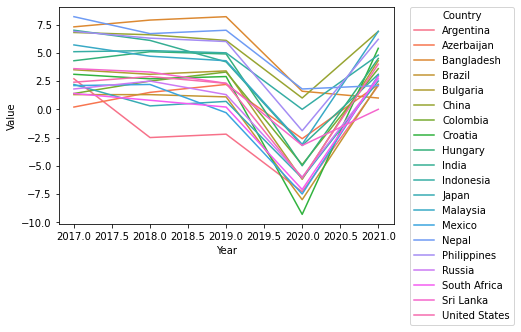

In [272]:
g = sns.lineplot(data=new_df,
                 x='Year', 
                 y='Value', 
                 hue='Country')
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)



The plot reveals the trend holds true as every country is set to fall considerably in 2020. While a recovery is estimated, a large majority of the countries seem to be struggling to return to levels experienced in 2019

## Financial policy Dataset 

With the effect of COVID-19 globally, it is interesting to look into the response financially by different countries

In [273]:
cov_df.describe(include=[np.object])

,Level of income,Region,Country,Level 1 policy measure,Level 2 policy measure,Detail
count,2453,2453,2453,2453,2453,2453
unique,4,7,149,6,19,1961
top,High income,ECA,South Korea,Banking Sector,Prudential,EBA proposed to adjust the capital impact for ...
freq,940,604,75,1296,850,15


The data set tracks measure that governments have taken to support their financial sector following the spread of the COVID-19 respiratory virus. Policies are classified according four main categories: liquidity/funding, financial institutions, financial markets and payments systems.

Initally we want to see what the general reaction has been policy wise to the virus, which countries have been most active and what policy has been implemented. 

In [274]:
cov_df['Level 1 policy measure'].value_counts()

Banking Sector            1296
Liquidity/funding          625
Financial Markets/NBFI     287
Payment systems            217
Insolvency                  18
Other                       10
Name: Level 1 policy measure, dtype: int64

Text(0.5, 1.0, 'Different Policy Responses')

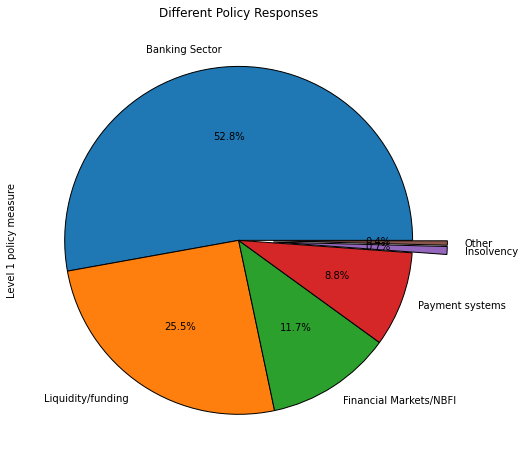

In [275]:
explode = (0, 0, 0, 0, 0.2, 0.2) 
cov_df['Level 1 policy measure'].value_counts().plot(kind='pie',
                                                     explode=explode, 
                                                     figsize=(8,8),
                                                     autopct="%1.1f%%", 
                                                     wedgeprops={'edgecolor':'black'})
plt.title("Different Policy Responses")


The initial outlook has been a response in the banking sector which makes up 52.8% of the policy implementation

Text(0.5, 1.0, 'Different Lvl 2 Policy Responses for Banking Sector')

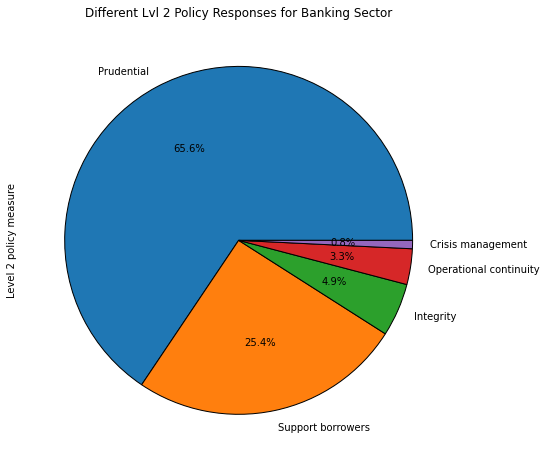

In [276]:
bank_sec = cov_df.loc[cov_df['Level 1 policy measure'] == 'Banking Sector']
bank_sec['Level 2 policy measure'].value_counts().plot(kind='pie', 
                                                       figsize=(8,8),
                                                       autopct="%1.1f%%", 
                                                       wedgeprops={'edgecolor':'black'})
plt.title("Different Lvl 2 Policy Responses for Banking Sector")

Text(0.5, 1.0, 'Different Lvl 2 Policy Responses for Liquidity')

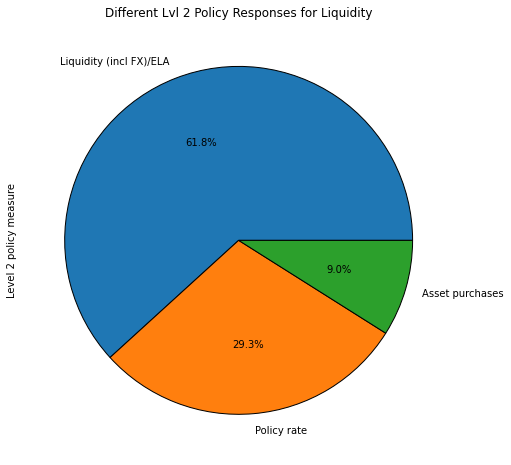

In [277]:
liq_sec = cov_df.loc[cov_df['Level 1 policy measure'] == 'Liquidity/funding ']
liq_sec['Level 2 policy measure'].value_counts().plot(kind='pie', 
                                                      figsize=(8,8),
                                                      autopct="%1.1f%%",
                                                      wedgeprops={'edgecolor':'black'})
plt.title("Different Lvl 2 Policy Responses for Liquidity")

Text(0.5, 1.0, 'Different Lvl 2 Policy Responses for Financial Markets')

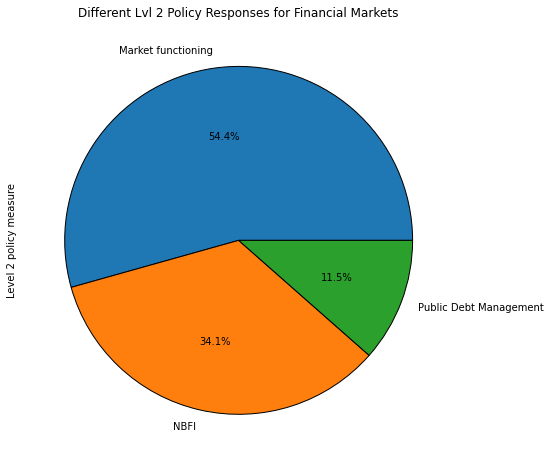

In [278]:
fin_sec = cov_df.loc[cov_df['Level 1 policy measure'] == 'Financial Markets/NBFI']
fin_sec['Level 2 policy measure'].value_counts().plot(kind='pie', 
                                                      figsize=(8,8),
                                                      autopct="%1.1f%%", 
                                                      wedgeprops={'edgecolor':'black'})
plt.title("Different Lvl 2 Policy Responses for Financial Markets")

Text(0.5, 1.0, 'Different Lvl 2 Policy Responses for Payment Systems')

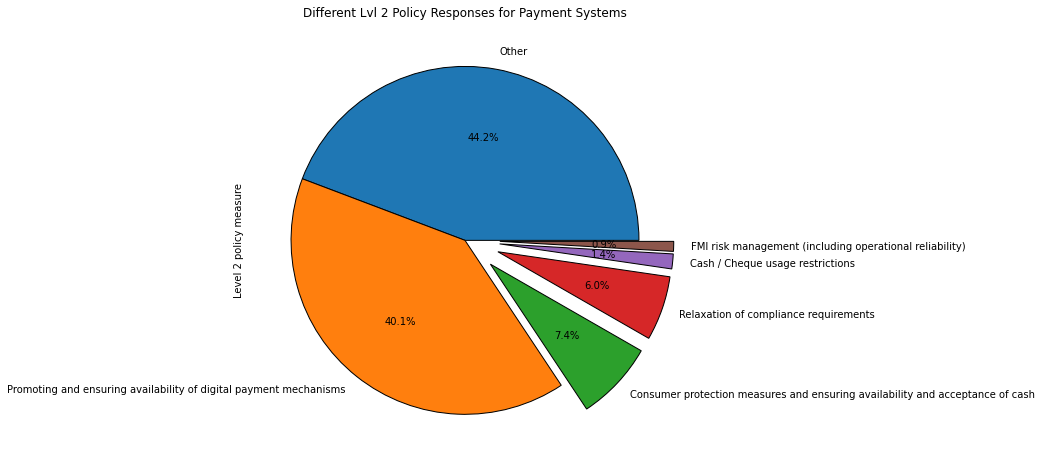

In [279]:
pay_sec = cov_df.loc[cov_df['Level 1 policy measure'] == 'Payment systems']
explode = (0, 0, 0.2, 0.2, 0.2, 0.2) 
pay_sec['Level 2 policy measure'].value_counts().plot(kind='pie',
                                                      explode=explode, 
                                                      figsize=(8,8),
                                                      autopct="%1.1f%%", 
                                                      wedgeprops={'edgecolor':'black'})
plt.title("Different Lvl 2 Policy Responses for Payment Systems")

Banking Sector: Within this sector, almost 2/3 of the decisions regard prudential banking decisions

Liquidity/funding: The majority focuses on liquidity, while a third of the decisions have effect policy rate

Financial markets:The focus is on Market functioning

Payments systems: The cases seem more specific to each individual instances but 40% of these decisions regard
'Promoting and ensuring availability of digital payment mechanisms' 



In [280]:
The dataset allows us to also see which countries have been the most active in terms of policy implementation.

SyntaxError: invalid syntax (<ipython-input-280-5bc6d44938e5>, line 1)

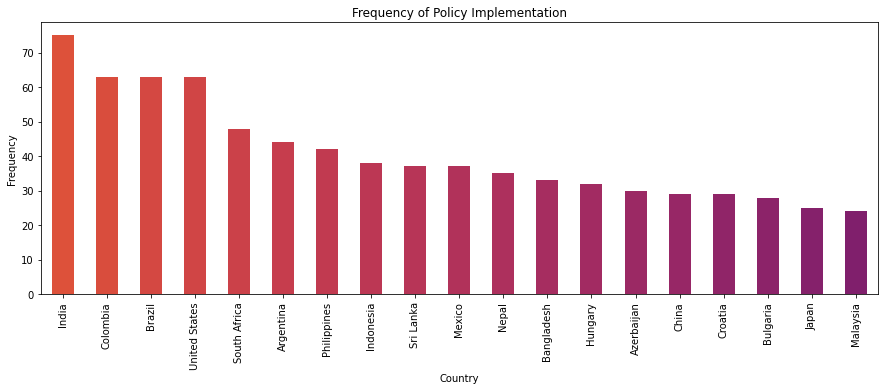

In [281]:
color = cm.inferno_r(np.linspace(.4, .8, 30))
new_cov_df = cov_df[cov_df.isin(countries).any(axis=1)]
new_cov_df['Country'].value_counts().plot(kind='bar', 
                                          figsize=(15,5), 
                                          color=color)
plt.title("Frequency of Policy Implementation")
plt.ylabel('Frequency')
plt.xlabel('Country');


The results show India as the most active in terms of policy comparative to the origin country of the virus China, 
which has half the amount of instances.

From the detail column, a wordcloud can also reveal any trends in the various details of the policies and what the focuse the seems to be in these decisions

In [282]:
text = " ".join(review for review in cov_df.Detail)
print ("There are {} words in the combination of all review.".format(len(text)))


There are 539814 words in the combination of all review.


In [283]:
# N0w tokenizing the text using TreebankWordTokenizer
tokenizer1 = nltk.tokenize.TreebankWordTokenizer()
tokens = tokenizer1.tokenize(text)
tokens[0:10]

['Require',
 'banks',
 'and',
 'insurance',
 'companies',
 'to',
 'ensure',
 'the',
 'safety',
 ',']

In [284]:
# Now normalization of the text using lemmatization
stemmer = nltk.stem.WordNetLemmatizer()
words_all = " ".join(stemmer.lemmatize(token) for token in tokens)
words_all[0:106]                     

'Require bank and insurance company to ensure the safety , smoothness and efficiency of financial service ;'

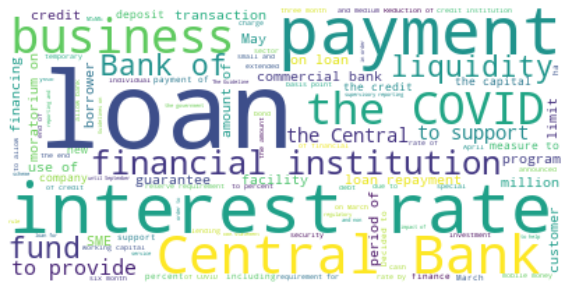

In [285]:
stopwords = set(STOPWORDS)
stopwords.update(["will" , 'be', 'bank' ,'to', 'the', 'day', 'month','COVID'])
wordcloud = WordCloud(stopwords = stopwords, background_color = "white").generate(words_all)
plt.figure(figsize = (10,10), facecolor = None) 
plt.imshow(wordcloud, interpolation = 'bilinear')
plt.axis('off')
plt.show()

In order to look at specific responses in the dataframe, the countries can be narrowed further for an easier comparison. As it incorporates a good range of countries who have all been affected by the virus, the BRICS model will be used ('Brazil','Russia','India','China','South Africa'). The United States will also be included as it is seen as the financial world leader.

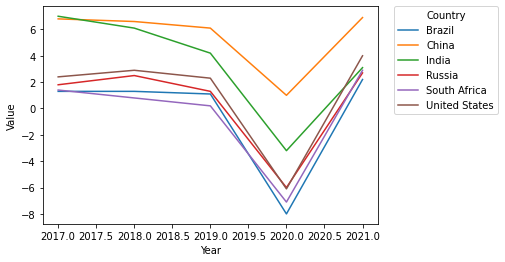

In [286]:
cntry = ['Brazil','Russia','India','China','South Africa','United States']
brics_df = gdp_df[gdp_df.isin(cntry).any(axis=1)]
g = sns.lineplot(data=brics_df, 
                 x='Year', 
                 y='Value',
                 hue='Country')
plt.legend(bbox_to_anchor=(1.05, 1), 
           loc=2, 
           borderaxespad=0.)




In [287]:
Plotting GDP once again reveals the prediction for each economy. 
Brazil: Brazil falls the largest % but recovers to a higher level in 2021
China: Does not experience negative growth and recovers considerably
India: Continues on a negative trend and does not fully recover in 2021
Russia: Experiences negative growth but recovers to similar level in 2021
South Africa: Experiences significant negative growth but recovers past 2019 levels
United States: Considerable negative growth but has greatest recovery

SyntaxError: invalid syntax (<ipython-input-287-3b6f78ae28d0>, line 1)

With each individual GDP growth figure in mind, the specific responses are now considered. This is also measure alongside a timeline of when the countries are implementing these issues to show when each individual country reacted.

In [288]:
def timeline(dates, names):
    levels = np.tile([-9,9-7, 7, -5, 5, -3, 3, -1, 1],
                 int(np.ceil(len(dates)/6)))[:len(dates)]

    # Create figure and plot a stem plot with the date
    fig, ax = plt.subplots(figsize=(20, 4), constrained_layout=True)
    ax.set(title="Country Financial Policy")

    markerline, stemline, baseline = ax.stem(dates, levels,
                                         linefmt="C3-", basefmt="k-",
                                         use_line_collection=True)

    plt.setp(markerline, mec="k", mfc="w", zorder=3)

    # Shift the markers to the baseline by replacing the y-data by zeros.
    markerline.set_ydata(np.zeros(len(dates)))

    # annotate lines
    vert = np.array(['top', 'bottom'])[(levels > 0).astype(int)]
    for d, l, r, va in zip(dates, levels, names, vert):
        ax.annotate(r, xy=(d, l), xytext=(-3, np.sign(l)*3),
                textcoords="offset points", va=va, ha="right")

    # format xaxis with 4 month intervals
    ax.get_xaxis().set_major_locator(mdates.MonthLocator(interval=1))
    ax.get_xaxis().set_major_formatter(mdates.DateFormatter("%b %Y"))
    plt.setp(ax.get_xticklabels(), rotation=30, ha="right")

    # remove y axis and spines
    ax.get_yaxis().set_visible(False)
    for spine in ["left", "top", "right"]:
        ax.spines[spine].set_visible(False)

    ax.margins(y=0.1)
    plt.show()

Text(0.5, 1.0, 'Different Policy Responses')

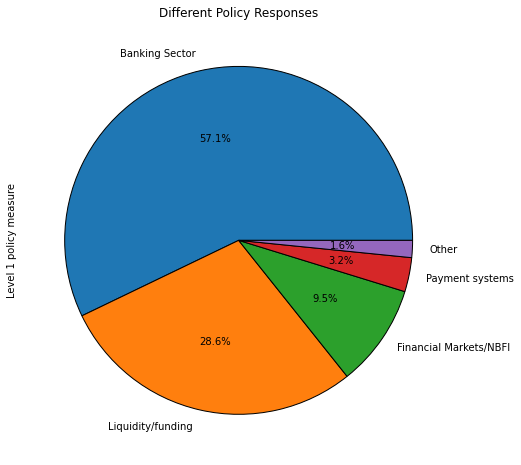

In [289]:
bra = cov_df.loc[cov_df['Country'] == 'Brazil']
bra['Level 1 policy measure'].value_counts().plot(kind='pie', 
                                                  figsize=(8,8),
                                                  autopct="%1.1f%%", 
                                                  wedgeprops={'edgecolor':'black'})
plt.title("Different Policy Responses")



Text(0.5, 1.0, 'Different Policy Responses')

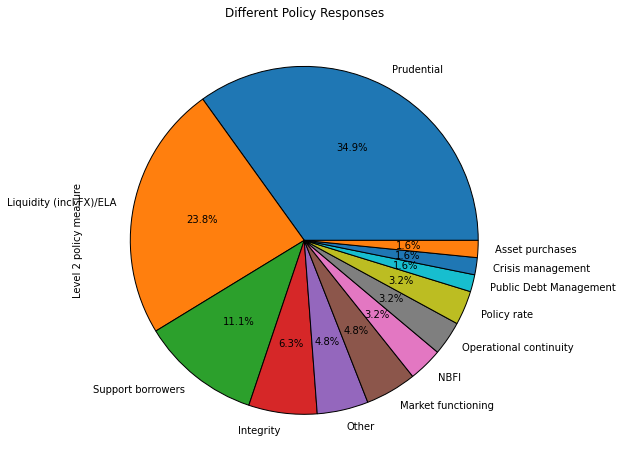

In [290]:
bra['Level 2 policy measure'].value_counts().plot(kind='pie', 
                                                  figsize=(8,8),
                                                  autopct="%1.1f%%", 
                                                  wedgeprops={'edgecolor':'black'})
plt.title("Different Policy Responses")

In [291]:
list1 = bra['Entry date'].tolist()
list2 = bra['Level 2 policy measure'].tolist()
bra_dates = list1
bra_names = list2



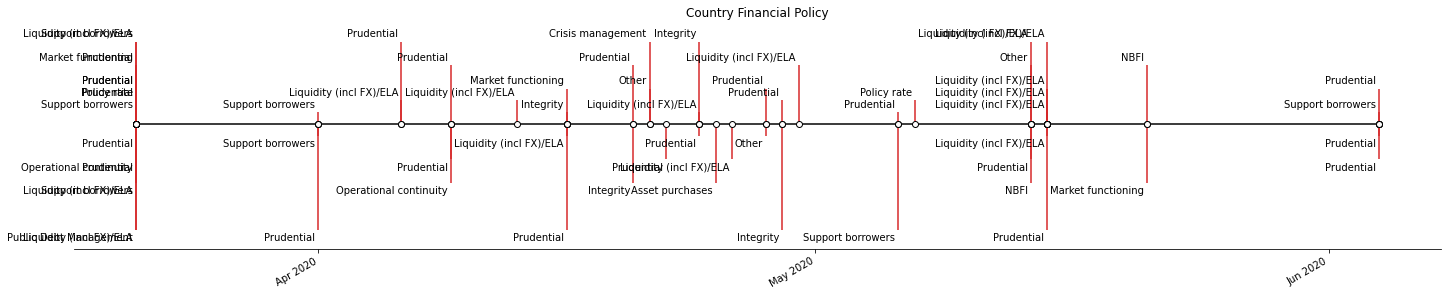

In [292]:
timeline(bra_dates, bra_names)

Brazils response has focused on prudential policy making and liquidity. After an initial surge in policy in March as a response to the first look at the virus, recurring policy surrounding liquidity seems to be a common theme.

Text(0.5, 1.0, 'Different Policy Responses')

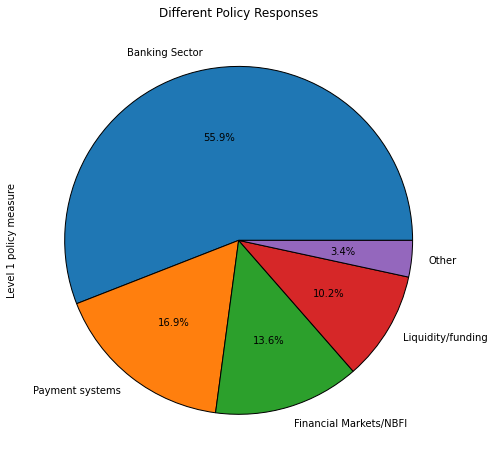

In [293]:
russ = cov_df.loc[cov_df['Country'] == 'Russian Federation']
russ['Level 1 policy measure'].value_counts().plot(kind='pie', 
                                                   figsize=(8,8),
                                                   autopct="%1.1f%%", 
                                                   wedgeprops={'edgecolor':'black'})
plt.title("Different Policy Responses")




Text(0.5, 1.0, 'Different Policy Responses')

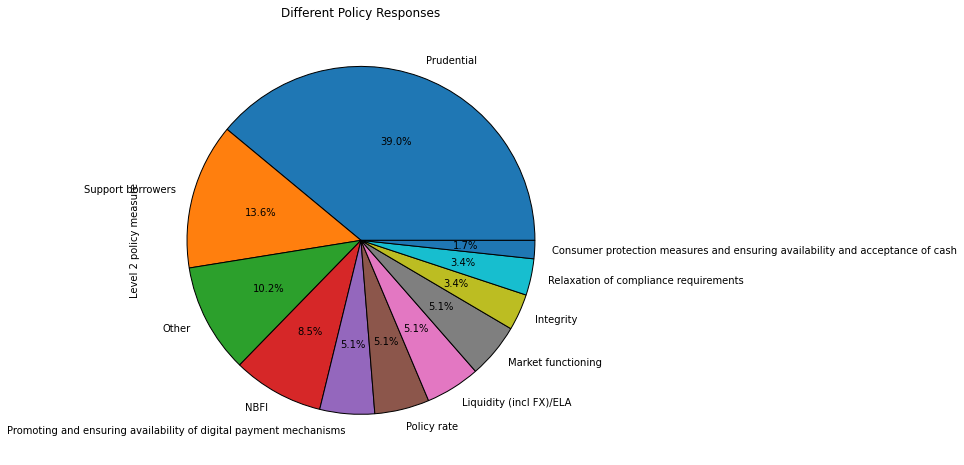

In [294]:
russ['Level 2 policy measure'].value_counts().plot(kind='pie', 
                                                  figsize=(8,8),
                                                  autopct="%1.1f%%", 
                                                  wedgeprops={'edgecolor':'black'})
plt.title("Different Policy Responses")

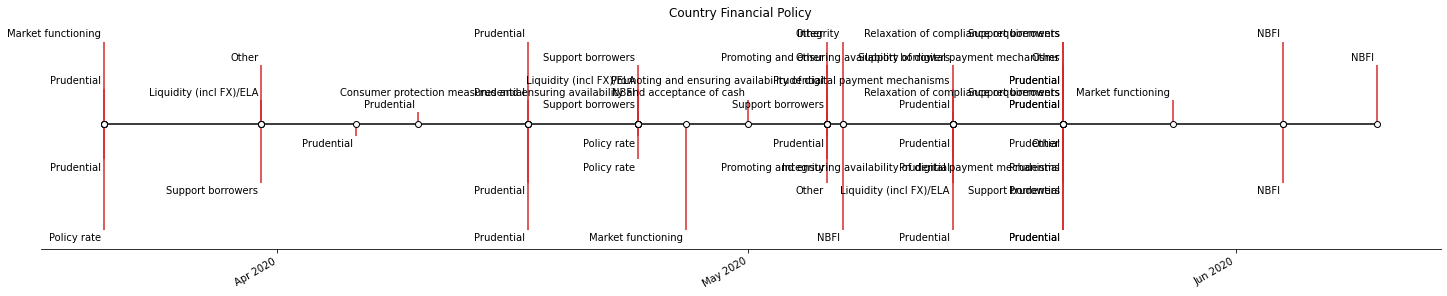

In [295]:
list1 = russ['Entry date'].tolist()
list2 = russ['Level 2 policy measure'].tolist()
russ_dates = list1
russ_names = list2
timeline(russ_dates, russ_names)

Russia's reaction also shows a similar theme with prudential policy in the banking sector dominating the response. However, there has also been a notable effort to support borrowers as well . Russia seemed to react more measurably in the initial phase and concurrent with the viruses lingering effect, saw a surge in decisions over April and May. As of June the focus seems to have turned to NBFI.

Text(0.5, 1.0, 'Different Policy Responses')

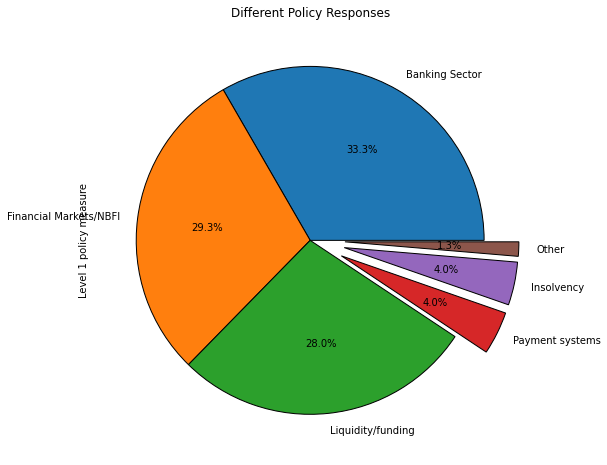

In [296]:
ind = cov_df.loc[cov_df['Country'] == 'India']
explode = (0, 0, 0, 0.2, 0.2, 0.2) 
ind['Level 1 policy measure'].value_counts().plot(kind='pie',
                                                  explode=explode, 
                                                  figsize=(8,8),
                                                  autopct="%1.1f%%", 
                                                  wedgeprops={'edgecolor':'black'})
plt.title("Different Policy Responses")




Text(0.5, 1.0, 'Different Policy Responses')

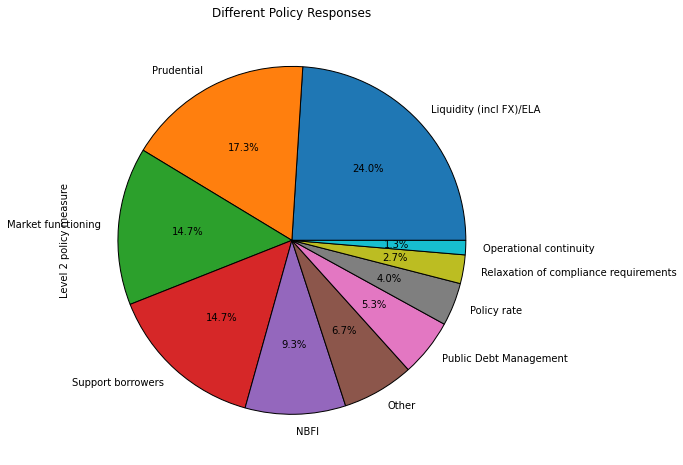

In [297]:
ind['Level 2 policy measure'].value_counts().plot(kind='pie', 
                                                  figsize=(8,8),
                                                  autopct="%1.1f%%", 
                                                  wedgeprops={'edgecolor':'black'})
plt.title("Different Policy Responses")

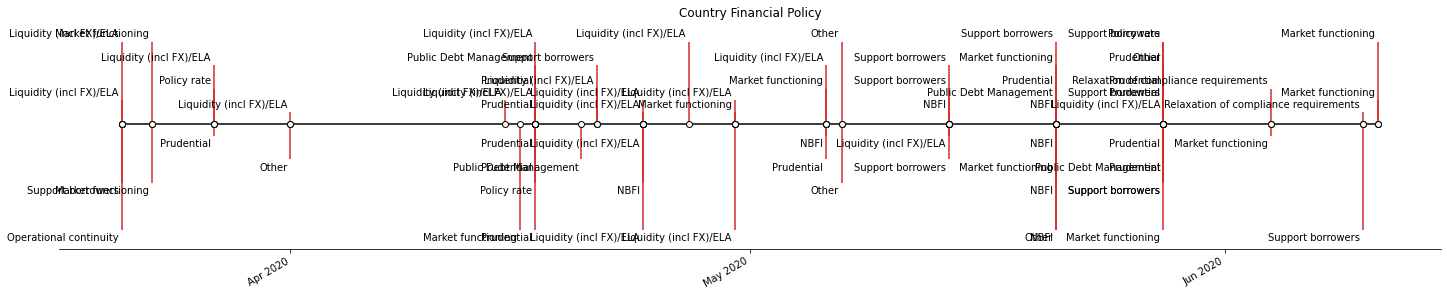

In [298]:
list1 = ind['Entry date'].tolist()
list2 = ind['Level 2 policy measure'].tolist()
ind_dates = list1
ind_names = list2
timeline(ind_dates, ind_names)




India was revealed earlier as the most active issuer of new policy. The timeline shows this them as there is a constant stream of different policies issued. India seems to have taken a different approach as there is a split between the banking sector, liquidity and financial markets. In comparison to other countries it will be interesting to see whether India's active role has a greater effect on the economy.

Text(0.5, 1.0, 'Different Policy Responses')

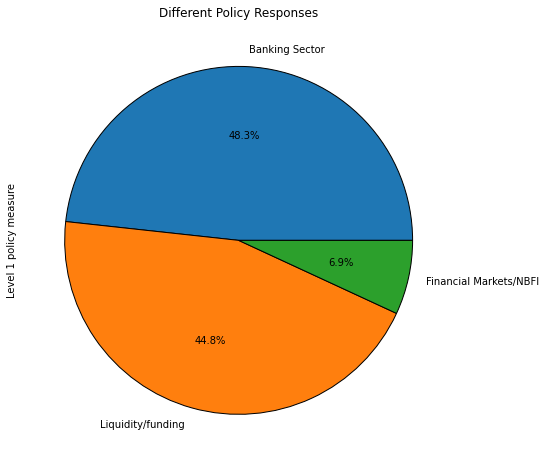

In [299]:
chi = cov_df.loc[cov_df['Country'] == 'China']
chi['Level 1 policy measure'].value_counts().plot(kind='pie', 
                                                  figsize=(8,8),
                                                  autopct="%1.1f%%", 
                                                  wedgeprops={'edgecolor':'black'})
plt.title("Different Policy Responses")




Text(0.5, 1.0, 'Different Policy Responses')

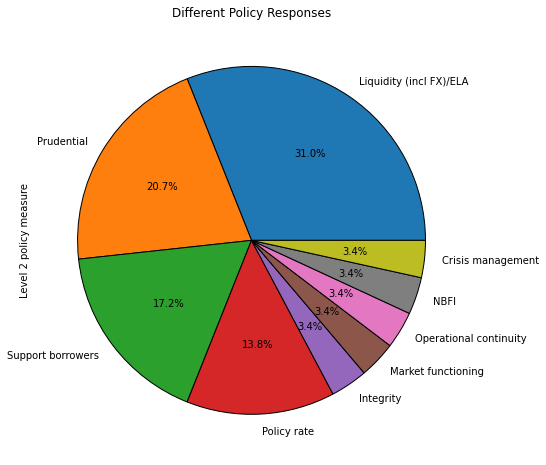

In [300]:
chi['Level 2 policy measure'].value_counts().plot(kind='pie', 
                                                  figsize=(8,8),
                                                  autopct="%1.1f%%", 
                                                  wedgeprops={'edgecolor':'black'})
plt.title("Different Policy Responses")

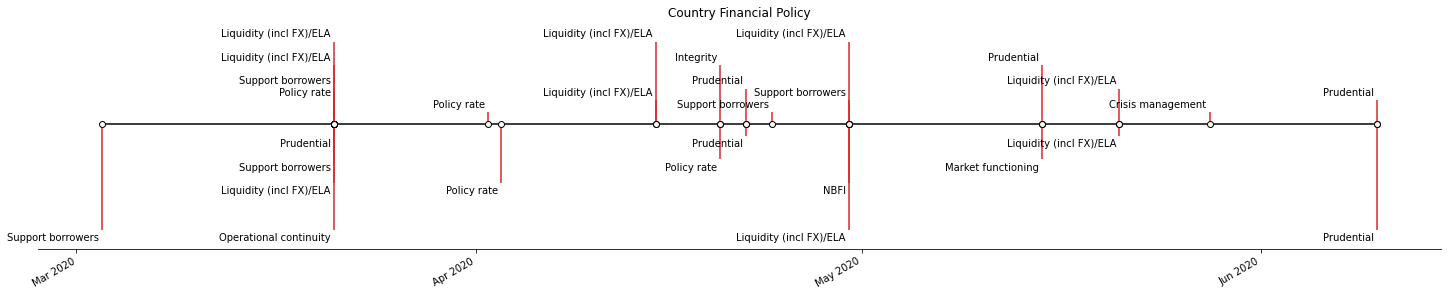

In [301]:
list1 = chi['Entry date'].tolist()
list2 = chi['Level 2 policy measure'].tolist()
chi_dates = list1
chi_names = list2
timeline(chi_dates, chi_names)




China, in contrast to India has a far more focused approach. Initially, much like the other nations there is a large amount of policy issued in mid-march but unlike the other nations, less reaction over the course of the next few months. This may be due to the fact that the virus was present far earlier and China was able to deal with it effectively. This may be model for other countries to follow and shows if the virus is managed effectively how need for policy is less frequent. Looking at Chinas GDP growth levels this may explain the high rise expected in 2021

Text(0.5, 1.0, 'Different Policy Responses')

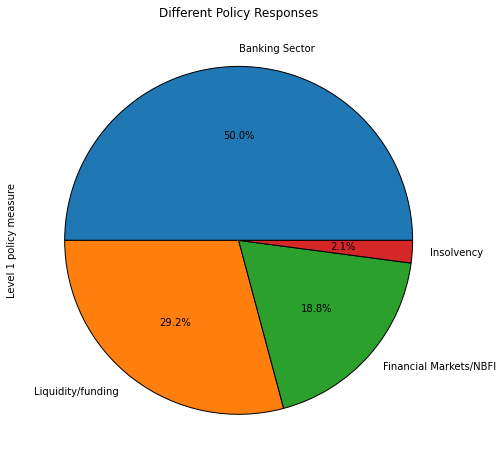

In [302]:
sa = cov_df.loc[cov_df['Country'] == 'South Africa']
sa['Level 1 policy measure'].value_counts().plot(kind='pie', 
                                                 figsize=(8,8),
                                                 autopct="%1.1f%%", 
                                                 wedgeprops={'edgecolor':'black'})
plt.title("Different Policy Responses")



Text(0.5, 1.0, 'Different Policy Responses')

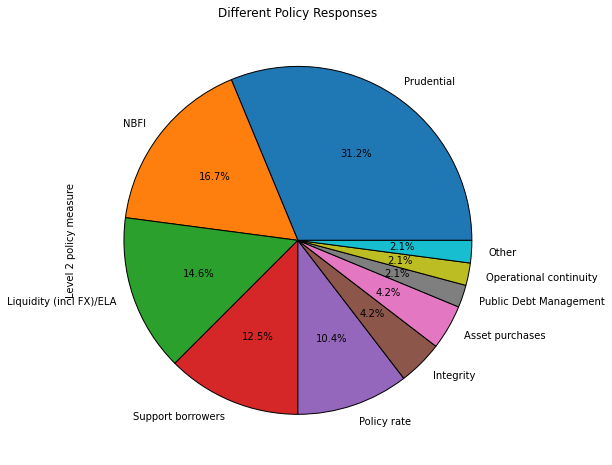

In [303]:
sa['Level 2 policy measure'].value_counts().plot(kind='pie', 
                                                  figsize=(8,8),
                                                  autopct="%1.1f%%", 
                                                  wedgeprops={'edgecolor':'black'})
plt.title("Different Policy Responses")

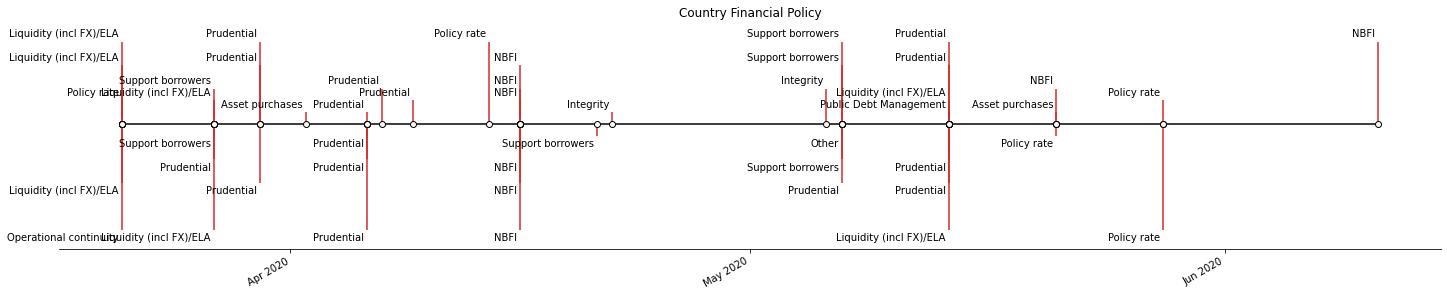

In [304]:
list1 = sa['Entry date'].tolist()
list2 = sa['Level 2 policy measure'].tolist()
sa_dates = list1
sa_names = list2
timeline(sa_dates, sa_names)

South Africa's response shows a large amount of activity in March and April. Again the trend seems to be consistent as the presence of the virus in some countries was enough to trigger the global response. South Africa follows the general trend with a focus on prudential policy throughout this time.

Text(0.5, 1.0, 'Different Policy Responses')

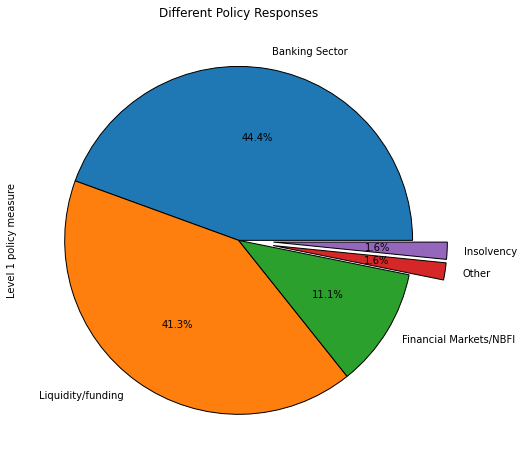

In [305]:
us = cov_df.loc[cov_df['Country'] == 'United States']
explode = (0, 0, 0, 0.2, 0.2) 
us['Level 1 policy measure'].value_counts().plot(kind='pie',
                                                 explode=explode, 
                                                 figsize=(8,8),
                                                 autopct="%1.1f%%",
                                                 wedgeprops={'edgecolor':'black'})
plt.title("Different Policy Responses")



Text(0.5, 1.0, 'Different Policy Responses')

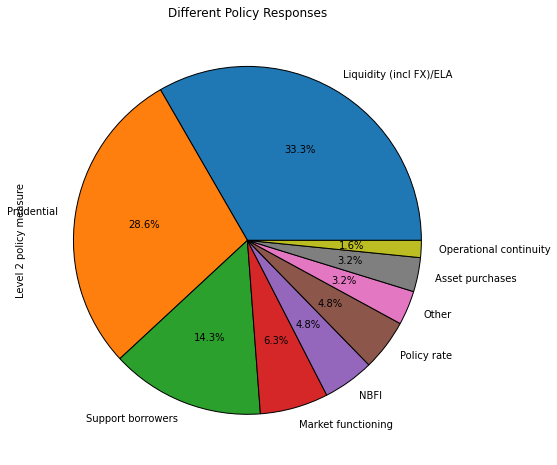

In [306]:
us['Level 2 policy measure'].value_counts().plot(kind='pie', 
                                                  figsize=(8,8),
                                                  autopct="%1.1f%%", 
                                                  wedgeprops={'edgecolor':'black'})
plt.title("Different Policy Responses")

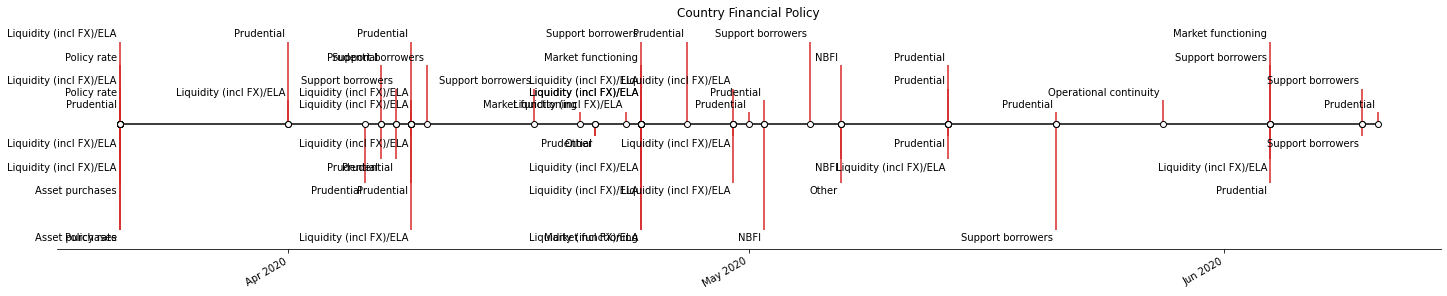

In [307]:
list1 = us['Entry date'].tolist()
list2 = us['Level 2 policy measure'].tolist()
us_dates = list1
us_names = list2
timeline(us_dates, us_names)





The United States has had three separate batches of bulk policy implementation, seemingly Mid-march, beginning and end of April. The emphasis however has been on liquidity followed by prudential policy.